## 1 Imports

In [47]:
import kagglehub

from sklearn.utils import shuffle

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

import torch

# Utilise CUDA (GPU) s'il est dispo, sinon CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## 2 Dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

In [8]:
# Chemin vers le dossier du dataset
base_path = "/Users/mounir/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1"

# Lecture des fichiers
true_df = pd.read_csv(f"{base_path}/True.csv")
fake_df = pd.read_csv(f"{base_path}/Fake.csv")

# Aperçu des données
print("True news:")
print(true_df.head(2))

print("\nFake news:")
print(fake_df.head(2))


True news:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   

Fake news:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  


In [9]:
true_df['target'] = ['True']*len(true_df)
fake_df['target'] = ['Fake']*len(fake_df)
df = pd.concat([true_df, fake_df], ignore_index=True)

In [37]:
print(df['target'].value_counts())
print(df['target'].value_counts()/len(df['target']))

target
Fake    23481
True    21417
Name: count, dtype: int64
target
Fake    0.522985
True    0.477015
Name: count, dtype: float64


The datsaset is well balanced

In [11]:
df['label'] = pd.get_dummies(df['target'], dtype=int)['Fake']   

In [12]:
df = shuffle(df).reset_index(drop=True)

## 3. Data Visualization

t-SNE projection of class-discriminative words based on TF-IDF scores

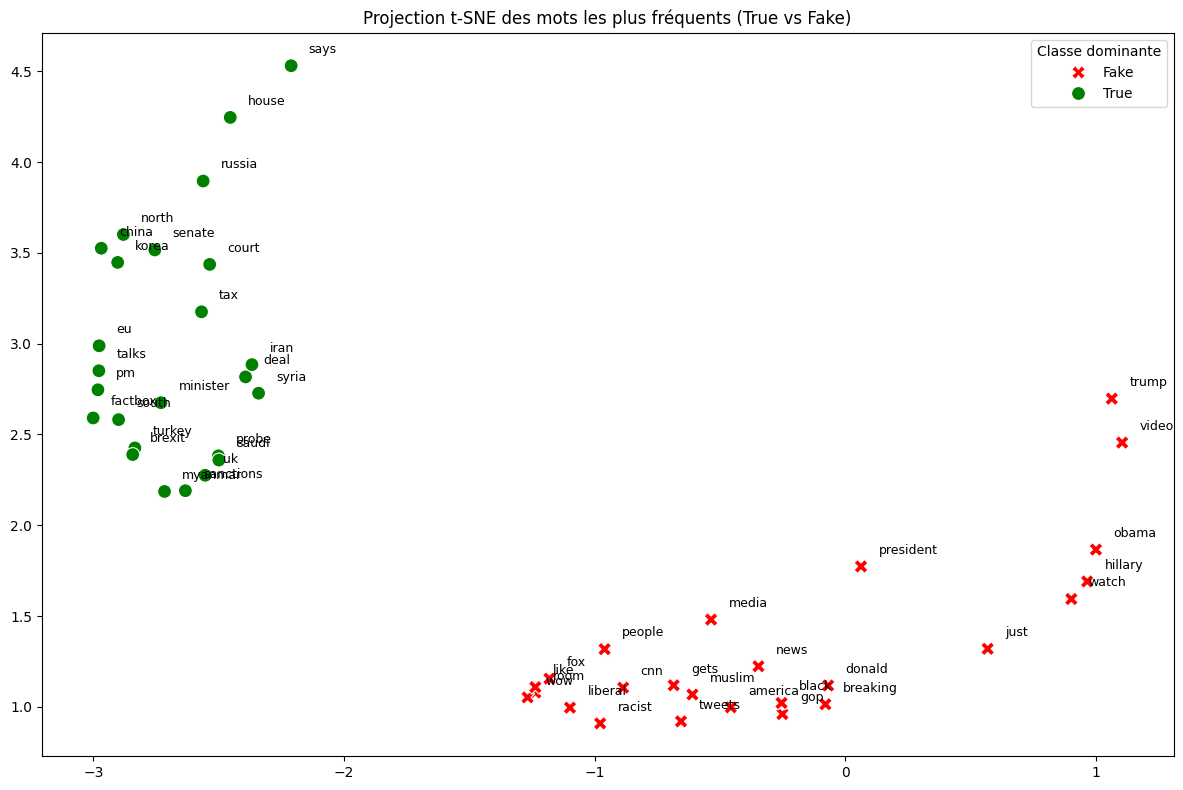

In [34]:
# 1. Nettoyage du DataFrame
df['title'] = df['title'].fillna("")
df['target'] = df['target'].astype(str)  # 'Fake' ou 'True'

# 2. Vectorisation TF-IDF
vectorizer = TfidfVectorizer(max_features=200, stop_words='english')
X = vectorizer.fit_transform(df['title'])
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X.toarray(), columns=feature_names)
tfidf_df['target'] = df['target'].values

# 3. Moyenne des scores TF-IDF par mot et par classe
true_mean = tfidf_df[tfidf_df['target'] == 'True'].drop(columns='target').mean()
fake_mean = tfidf_df[tfidf_df['target'] == 'Fake'].drop(columns='target').mean()
true_mean, fake_mean = true_mean.align(fake_mean, fill_value=0)

# 4. Vecteurs 2D [True score, Fake score] pour chaque mot
combined = pd.DataFrame({
    'word': true_mean.index,
    'true_score': true_mean.values,
    'fake_score': fake_mean.values
})

combined['class'] = combined.apply(lambda row: 'Fake' if row['fake_score'] > row['true_score'] else 'True', axis=1)
combined['diff'] = (combined['true_score'] - combined['fake_score']).abs()
combined = combined.sort_values(by='diff', ascending=False)
# Garder seulement les N mots les plus significatifs
N = 50
combined = combined.head(N)

# 5. t-SNE
vecs = combined[['true_score', 'fake_score']].values
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
vecs_2d = tsne.fit_transform(vecs)
combined['x'] = vecs_2d[:, 0]
combined['y'] = vecs_2d[:, 1]


# 6. Plot

palette = {'Fake': 'red', 'True': 'green'}
markers = {'Fake': 'X', 'True': 'o'}
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=combined,
    x='x',
    y='y',
    hue='class',
    style='class',
    palette=palette,
    markers=markers,
    s=100
)

for _, row in combined.iterrows():
    plt.text(row['x'] + 0.07, row['y'] + 0.07, row['word'], fontsize=9)

plt.title("Projection t-SNE des mots les plus fréquents (True vs Fake)")
plt.xlabel("")
plt.ylabel("")
plt.legend(title='Classe dominante')
plt.tight_layout()
plt.show()



## 4 Data split

In [40]:
from sklearn.model_selection import train_test_split

# 1. Split : train 70% / test+val 30%
x_train, x_temp, y_train, y_temp = train_test_split(
    df['title'],
    df['label'],
    test_size=0.3,
    random_state=2018,
    stratify=df['target']
)

# 2. Split : test+val → test 15%, val 15%
x_test, x_val, y_test, y_val = train_test_split(
    x_temp,
    y_temp,
    test_size=0.5,
    random_state=2018,
    stratify=y_temp
)

# 3. Affichage des tailles
print("x_train :", x_train.shape)
print("x_test  :", x_test.shape)
print("x_val   :", x_val.shape)

# 4. Répartition des classes
print("\n y_train :")
print(y_train.value_counts())
print("\n y_test :")
print(y_test.value_counts())
print("\n y_val :")
print(y_val.value_counts())


x_train : (31428,)
x_test  : (6735,)
x_val   : (6735,)

 y_train :
label
1    16436
0    14992
Name: count, dtype: int64

 y_test :
label
1    3522
0    3213
Name: count, dtype: int64

 y_val :
label
1    3523
0    3212
Name: count, dtype: int64


## 5 Model and tokenizer selection

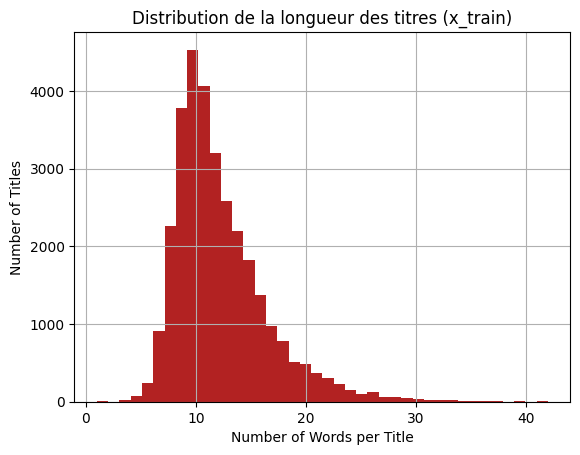

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [41]:
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
import pandas as pd

# 1. Charger le modèle BERT et le tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# 2. Visualiser la distribution du nombre de mots par titre (x_train)
seq_lengths = [len(title.split()) for title in x_train]
pd.Series(seq_lengths).hist(bins=40, color='firebrick')
plt.xlabel('Number of Words per Title')
plt.ylabel('Number of Titles')
plt.title("Distribution de la longueur des titres (x_train)")
plt.show()

# 3. Exemple simple de tokenisation
sample_data = ["Build fake news model.", "Using BERT."]
tokens = tokenizer.batch_encode_plus(sample_data, padding=True, truncation=True)
print(tokens)


## 6 Data Tokenization

In [42]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

# 1. Paramètre de longueur maximale (empirique, basé sur les titres)
MAX_LENGTH = 15

# 2. Tokenisation + encodage des jeux de données
tokens_train = tokenizer.batch_encode_plus(
    x_train.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors=None
)

tokens_val = tokenizer.batch_encode_plus(
    x_val.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors=None
)

tokens_test = tokenizer.batch_encode_plus(
    x_test.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors=None
)

# 3. Conversion en tenseurs PyTorch
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

# 4. Création des DataLoaders
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_dataloader = DataLoader(val_data, sampler=RandomSampler(val_data), batch_size=batch_size)


## 7 Model creation and training

In [44]:
import torch
import torch.nn as nn
from transformers import AutoModel
from torch.optim import AdamW

# 1. Freeze les poids de BERT pour n'entraîner que la tête
for param in bert.parameters():
    param.requires_grad = False

# 2. Définition de l'architecture personnalisée
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, attention_mask):
        cls_output = self.bert(input_ids, attention_mask=attention_mask)['pooler_output']
        x = self.fc1(cls_output)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# 3. Initialisation du modèle
model = BERTClassifier(bert)
model.to(device)


# 4. Optimiseur et fonction de perte
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.NLLLoss()

# 5. Fonction d'entraînement
def train():
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and step != 0:
            print(f"  Batch {step} / {len(train_dataloader)}")

        input_ids, attention_mask, labels = [item.to(device) for item in batch]

        model.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

# 6. Fonction d'évaluation (validation)
def evaluate():
    print("\n🔎 Evaluation ...")
    model.eval()
    total_loss = 0

    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and step != 0:
            print(f"  Batch {step} / {len(val_dataloader)}")

        input_ids, attention_mask, labels = [item.to(device) for item in batch]

        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_dataloader)
    return avg_loss

# 7. Entraînement du modèle
epochs = 2
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(epochs):
    print(f"\n🌱 Epoch {epoch + 1} / {epochs}")

    train_loss = train()
    valid_loss = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"\n✅ Training loss    : {train_loss:.3f}")
    print(f"✅ Validation loss  : {valid_loss:.3f}")



🌱 Epoch 1 / 2
  Batch 50 / 983
  Batch 100 / 983
  Batch 150 / 983
  Batch 200 / 983
  Batch 250 / 983
  Batch 300 / 983
  Batch 350 / 983
  Batch 400 / 983
  Batch 450 / 983
  Batch 500 / 983
  Batch 550 / 983
  Batch 600 / 983
  Batch 650 / 983
  Batch 700 / 983
  Batch 750 / 983
  Batch 800 / 983
  Batch 850 / 983
  Batch 900 / 983
  Batch 950 / 983

🔎 Evaluation ...
  Batch 50 / 211
  Batch 100 / 211
  Batch 150 / 211
  Batch 200 / 211

✅ Training loss    : 0.564
✅ Validation loss  : 0.484

🌱 Epoch 2 / 2
  Batch 50 / 983
  Batch 100 / 983
  Batch 150 / 983
  Batch 200 / 983
  Batch 250 / 983
  Batch 300 / 983
  Batch 350 / 983
  Batch 400 / 983
  Batch 450 / 983
  Batch 500 / 983
  Batch 550 / 983
  Batch 600 / 983
  Batch 650 / 983
  Batch 700 / 983
  Batch 750 / 983
  Batch 800 / 983
  Batch 850 / 983
  Batch 900 / 983
  Batch 950 / 983

🔎 Evaluation ...
  Batch 50 / 211
  Batch 100 / 211
  Batch 150 / 211
  Batch 200 / 211

✅ Training loss    : 0.471
✅ Validation loss  : 0.417


## 8 Model evaluation

In [45]:
from sklearn.metrics import classification_report
import numpy as np
import torch

# 1. Prédiction sans calcul de gradients
with torch.no_grad():
    outputs = model(test_seq.to(device), test_mask.to(device))
    outputs = outputs.detach().cpu().numpy()


# 2. Conversion en classes (0 ou 1)
preds = np.argmax(outputs, axis=1)

# 3. Évaluation des performances
print("✅ Résultats sur le jeu de test :")
print(f"Shape des prédictions : {preds.shape}")
print(classification_report(test_y, preds))


✅ Résultats sur le jeu de test :
Shape des prédictions : (6735,)
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      3213
           1       0.91      0.75      0.82      3522

    accuracy                           0.83      6735
   macro avg       0.84      0.83      0.83      6735
weighted avg       0.84      0.83      0.83      6735



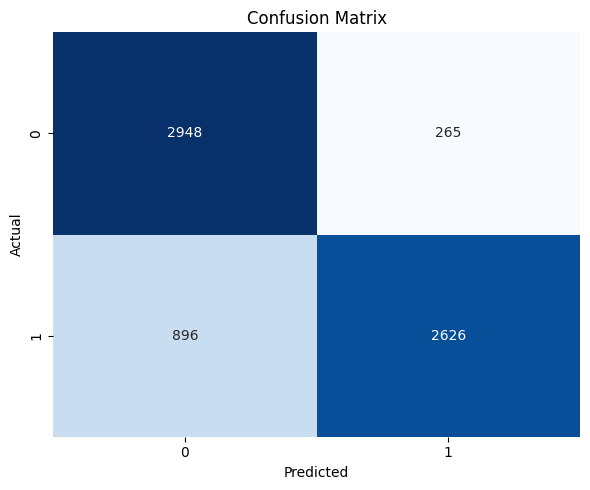

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matrice de confusion
conf_mat = confusion_matrix(test_y.numpy(), preds)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
